# Covermap Comparison

**Author:** Adam Yang (ayang115@umd.edu)

**Description:** Compares datasets against test sets

**Crop Maps Used:** Harvest Togo & Kenya, Copernicus Land Cover, ESA CCI Land Cover Africa, GLAD Global Cropland Extent

In [1]:
import os
import geemap
import cartopy.io.shapereader as shpreader 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio as rio

from pathlib import Path
from shapely import wkt
from sklearn.metrics import classification_report 
from shapely.geometry import Point, MultiPolygon, GeometryCollection 

c:\Users\adamf\anaconda3\envs\intercomparison\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
import ee

ee.Authenticate()

ee.Initialize()


Successfully saved authorization token.


### **Setup**

**Constants**

In [31]:
COUNTRIES = ["Kenya", "Togo", "Tanzania"]
TEST_COUNTRIES = ["Kenya", "Togo", "Tanzania_CEO_2019"]
DATA_PATH = "../data/datasets/"
TEST_CODE = {"Kenya": "KEN", "Togo": "TGO", "Tanzania_CEO_2019": "TZA"} # for NE boundaries

In [32]:
DATASET_PATH = Path(DATA_PATH).glob("*")
TARGET_PATHS = [p for p in DATASET_PATH if p.stem in TEST_COUNTRIES] # test data path

In [33]:
# country boundaries
NE_GDF = gpd.read_file(
    shpreader.natural_earth(
        resolution='10m', 
        category='cultural', 
        name='admin_1_states_provinces')
)


In [34]:
REDUCER = ee.Reducer.mode()
REDUCER_STR = "mode"

**Functions**

In [35]:
# Function used in map function to extract from feature collection
def raster_extraction(image, resolution, fc, projection="EPSG:4326"):
    
    # Filter feature collection to only points within image
    fc_sub = fc.filterBounds(image.geometry())

    feature = image.reduceRegions(
        collection=fc_sub,
        reducer=REDUCER,
        scale=resolution,
        crs=projection
    )
    return feature

In [36]:
# Convert sklearn classification report dict to 
def generate_report(dataset_name, true, pred):
    report = classification_report(true, pred, output_dict=True)
    return pd.DataFrame(data = {
        "dataset": dataset_name, 
        "crop_f1": report["1"]["f1-score"], 
        "accuracy": report["accuracy"], 
        "crop_support": report["1"]["support"], 
        "noncrop_support": report["0"]["support"], 
        "crop_recall": report["1"]["recall"], 
        "noncrop_recall": report["0"]["recall"],
        "crop_precision": report["1"]["precision"],
        "noncrop_precision": report["0"]["precision"] 
        }, index=[0])

In [37]:
# Creates ee.Feature from longitude and latitude coordinates from a dataframe
def create_point(row):
    geom = ee.Geometry.Point(row.lon, row.lat)
    prop = dict(row[['lon', 'lat', 'binary', 'country']])

    return ee.Feature(geom, prop)

In [38]:
# filters out data in gdf that is not within country bounds 
def filter_by_bounds(country: str, gdf: gpd.GeoDataFrame):
    boundary = NE_GDF.loc[NE_GDF['adm1_code'].str.startswith(country), :].copy()

    if boundary.crs == None:
        boundary = boundary.set_crs('epsg:4326')
    if boundary.crs != 'epsg:4326':
        boundary = boundary.to_crs('epsg:4326')

    boundary = GeometryCollection([x for x in boundary['geometry']])

    mask = gdf.within(boundary)
    filtered = gdf.loc[mask].copy()

    return filtered

In [39]:
# Read in test data from dvc 
def read_test(path: str):
    test = pd.read_csv(path)
    test = gpd.GeoDataFrame(test, geometry=gpd.points_from_xy(test.lon, test.lat), crs='epsg:4326')
    test = test.loc[test['subset']=='testing']
    test['binary'] = test['class_probability'].apply(lambda x: 1 if x >= 0.5 else 0)

    return test

In [40]:
# Adds buffer to feature collection points
def bufferPoints(radius, bounds):
    def function(pt):
        pt = ee.Feature(pt)
        return pt.buffer(radius).bounds() if bounds else pt.buffer(radius)
    return function

### **Generate Test Data**

In [59]:
# Create a Testing geodataframe. Extracts data based on a list of dataset paths. Generate a dataframe for each country, then concats dataframes into one. 

def generate_test_data(target_paths: list):
    test_set = []
    
    for p in target_paths:
        # Set dict key name
        key = p.stem

        print(key)

        # Read in data and extract test values and points 
        gdf = read_test(p)
        
        before = len(gdf)
        gdf = filter_by_bounds(TEST_CODE[key], gdf)
        after = len(gdf)
        print("Points removed: " + str(before - after))


        test_set.append(gdf)

    # Combine all extracted countries 
    test = gpd.GeoDataFrame(pd.concat(test_set))
    test.reset_index(inplace=True, drop=True)
    
    return test

In [60]:
test_data = generate_test_data(TARGET_PATHS)
# test_data.to_csv('../../intercomparison-data/test_data.csv')

Kenya
Tanzania_CEO_2019
Togo


In [61]:
# test_data = pd.read_csv("../../intercomparison-data/test_data.csv").drop("Unnamed: 0", axis=1)
# test_data["geometry"] = test_data["geometry"].apply(wkt.loads)
# test_data = gpd.GeoDataFrame(test_data, crs="epsg:4326")

In [62]:
test_data.head()

,lon,lat,start_date,end_date,source,class_probability,num_labelers,subset,analysis_duration,email,country,dataset,eo_data,eo_lon,eo_lat,eo_file,eo_status,geometry,binary
0,34.386282,0.725122,2019-01-01,2020-12-31,noncrop_labels_v2,0.0,1,testing,NaN,NaN,Kenya,Kenya,"[[-11.74174313771244, -16.760872534791257, 952...",34.386296,0.725165,min_lat=0.7244_min_lon=34.3856_max_lat=0.7258_...,eo_data_complete,POINT (34.38628 0.72512),0
1,34.466496,0.621939,2019-01-01,2020-12-31,noncrop_labels_v2,0.0,1,testing,NaN,NaN,Kenya,Kenya,"[[-6.565833796243928, -12.449147022074829, 951...",34.466516,0.621949,min_lat=0.6212_min_lon=34.4658_max_lat=0.6227_...,eo_data_complete,POINT (34.46650 0.62194),0
2,34.090158,0.459661,2019-01-01,2020-12-31,noncrop_labels_v2,0.0,1,testing,NaN,NaN,Kenya,Kenya,"[[-11.0494582737447, -14.924609692863193, 1157...",34.090122,0.459623,min_lat=0.4589_min_lon=34.0894_max_lat=0.4604_...,eo_data_complete,POINT (34.09016 0.45966),0
3,34.054859,0.226497,2019-01-01,2020-12-31,noncrop_labels_v2,0.0,1,testing,NaN,NaN,Kenya,Kenya,"[[-9.902949034787321, -15.70680808103578, 1174...",34.054818,0.226510,min_lat=0.2258_min_lon=34.0541_max_lat=0.2272_...,eo_data_complete,POINT (34.05486 0.22650),0
4,33.951959,0.096834,2019-01-01,2020-12-31,noncrop_labels_v2,0.0,1,testing,NaN,NaN,Kenya,Kenya,"[[-14.47299462942356, -17.955564415668587, 106...",33.951961,0.096793,min_lat=0.0961_min_lon=33.9512_max_lat=0.0976_...,eo_data_complete,POINT (33.95196 0.09683),0


### **Examine test set**

<AxesSubplot:>

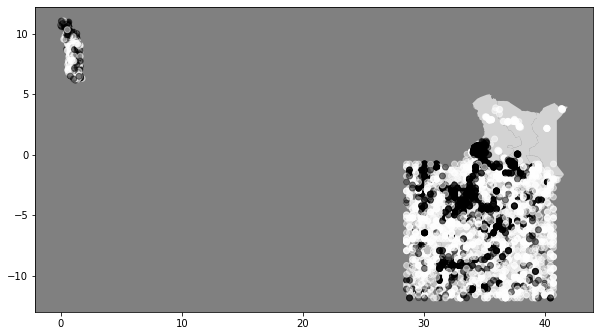

In [63]:
# Shapefiles for test set countries
KEN_mask = NE_GDF[NE_GDF["adm1_code"].str.startswith("KEN")].copy()
TGO_mask = NE_GDF[NE_GDF["adm1_code"].str.startswith("TGO")].copy()
TZA_mask = NE_GDF[NE_GDF["adm1_code"].str.startswith("TZA")].copy()
masks = [KEN_mask, TZA_mask]

# Make sure the shapefile has EPSG:4326, otherwise convert it
for boundary in masks:
    if boundary.crs == None:
        boundary = boundary.set_crs('epsg:4326')
    if boundary.crs != 'epsg:4326':
        boundary = boundary.to_crs('epsg:4326')
    boundary['roi'] = True
    boundary.reset_index(inplace=True, drop=True)
    boundary.dissolve('roi')

df = gpd.GeoDataFrame(pd.concat(masks)).set_crs('epsg:4326')

fig, ax = plt.subplots(figsize = (10,10))
ax.set_facecolor("gray")
df["geometry"].to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
test_data.plot(ax=ax, column='binary', alpha=0.5, cmap='binary')

Support for each country

In [64]:
print(
    len(test_data[test_data['country']=='Togo']), 
    len(test_data[test_data['country']=='Kenya']), 
    len(test_data[test_data['country']=='Tanzania'])
    )

355 829 2710


Assert no overlap

In [65]:
tgo = test_data.loc[test_data['country']=='Togo'].copy()
ken = test_data.loc[test_data['country']=='Kenya'].copy()
tan = test_data.loc[test_data['country']=='Tanzania_CEO_2019'].copy()

In [66]:
assert ~ken.overlaps(tan).all(), "Overlap detected!"
assert ~ken.overlaps(tgo).all(), "Overlap detected!"

assert ~tan.overlaps(ken).all(), "Overlap detected!"
assert ~tan.overlaps(tgo).all(), "Overlap detected!"

assert ~tgo.overlaps(tan).all(), "Overlap detected!"
assert ~tgo.overlaps(ken).all(), "Overlap detected!"

c:\Users\adamf\anaconda3\envs\intercomparison\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


### **Generate earth engine points**

In [67]:
# Create feature collections for each subset
togo_coll = ee.FeatureCollection(test_data.loc[test_data["country"]=="Togo"].apply(create_point, axis=1).to_list()).map(bufferPoints(10, False))
kenya_coll = ee.FeatureCollection(test_data.loc[test_data["country"]=="Kenya"].apply(create_point, axis=1).to_list()).map(bufferPoints(10, False))
tanz_coll = ee.FeatureCollection(test_data.loc[test_data["country"]=="Tanzania"].apply(create_point, axis=1).to_list()).map(bufferPoints(10, False))

# Feature collection including all test points
test_coll = ee.FeatureCollection(test_data.apply(create_point, axis=1).to_list()).map(bufferPoints(10, False))


### **Harvest Data**

In [68]:
HARVEST_PATHS = {
    "projects/sat-io/open-datasets/nasa-harvest/togo_cropland_binary" : togo_coll, 
    "projects/sat-io/open-datasets/nasa-harvest/kenya_cropland_binary" : kenya_coll,
    "users/adadebay/Tanzania_cropland_2019" : tanz_coll}

In [69]:
harvest = []
for map in HARVEST_PATHS.keys():
    name = map.split('/')[-1]
    print(name)

    # Convert image to image collection
    sampled = ee.ImageCollection([ee.Image(map)])
    sampled = sampled.map(lambda x: raster_extraction(x, 10, HARVEST_PATHS[map])).flatten()
    
    # Convert to gdf
    sampled = geemap.ee_to_gdf(sampled)
    
    # Binarize 
    sampled["samples"] = sampled[REDUCER_STR].apply(lambda x: 1 if x>=0.5 else 0) 

    harvest.append(sampled)

harvest = pd.concat(harvest)

# harvest.to_csv('../../intercomparison-data/harvest.csv')

togo_cropland_binary
kenya_cropland_binary
Tanzania_cropland_2019


In [70]:
# Join test and sampled sets
test_data["harvest"] = pd.merge(test_data, harvest, on=["lat", "lon"], how="left")["samples"]

### **[COP](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global), [ESA](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100), [GLAD](https://glad.umd.edu/dataset/croplands)**

In [71]:
copernicus = ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V-C3/Global")
esa = ee.ImageCollection("ESA/WorldCover/v100")
glad = ee.ImageCollection("users/potapovpeter/Global_cropland_2019")

In [72]:
cop_clipped = copernicus.select("discrete_classification").filterDate("2019-01-01", "2019-12-31")
cop_sampled = geemap.ee_to_gdf(cop_clipped.map(lambda x: raster_extraction(x, 100, test_coll)).flatten())
cop_sampled["cop_class"] = cop_sampled[REDUCER_STR].apply(lambda x: 1 if x==40 else 0)

esa_sampled = geemap.ee_to_gdf(esa.map(lambda x: raster_extraction(x, 10, test_coll)).flatten())
esa_sampled["esa_class"] = esa_sampled[REDUCER_STR].apply(lambda x: 1 if x==40 else 0)

glad_sampled = geemap.ee_to_gdf(glad.map(lambda x: raster_extraction(x, 30, test_coll)).flatten()).rename(columns={REDUCER_STR: "glad_class"})

In [73]:
test_data["cop"] = pd.merge(test_data, cop_sampled, on=["lat", "lon"], how="left")["cop_class"]
test_data["esa"] = pd.merge(test_data, esa_sampled, on=["lat", "lon"], how="left")["esa_class"]
test_data['glad'] = pd.merge(test_data, glad_sampled, on=["lat", "lon"], how="left")["glad_class"]

## **Evaluation Results**

**Compute results**

In [74]:
results = {}

for key in COUNTRIES:
    results[key] = pd.DataFrame(columns=["dataset", "accuracy", "crop_f1", "crop_support", "noncrop_support", 
        "crop_precision", "crop_recall", "noncrop_precision", "noncrop_recall"])

In [75]:
for country, df in test_data.groupby("country"):
    for dataset in ["harvest", "cop", "esa", "glad"]:
        print(country + ": " + dataset)
        
        # Remove na values
        temp = df[["binary", dataset]].dropna()
        print("Points dropped: " + str(len(df) - len(temp)))

        results[country] = pd.concat([results[country], generate_report(dataset, temp["binary"], temp[dataset])])

Kenya: harvest
Points dropped: 8
Kenya: cop
Points dropped: 0
Kenya: esa
Points dropped: 0
Kenya: glad
Points dropped: 0
Tanzania: harvest
Points dropped: 315
Tanzania: cop
Points dropped: 0
Tanzania: esa
Points dropped: 0
Tanzania: glad
Points dropped: 0
Togo: harvest
Points dropped: 0
Togo: cop
Points dropped: 0
Togo: esa
Points dropped: 0
Togo: glad
Points dropped: 0


**Togo**

In [79]:
results["Togo"]

,dataset,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,harvest,0.785915,0.750000,152,203,0.750000,0.750000,0.812808,0.812808
0,cop,0.692958,0.569170,152,203,0.712871,0.473684,0.685039,0.857143
0,esa,0.754930,0.626609,152,203,0.901235,0.480263,0.711679,0.960591
0,glad,0.715493,0.562771,152,203,0.822785,0.427632,0.684783,0.931034


**Kenya**

In [80]:
results["Kenya"]

,dataset,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,harvest,0.951279,0.964602,571,250,0.974955,0.954466,0.900763,0.944000
0,cop,0.910736,0.936317,571,258,0.920474,0.952715,0.886555,0.817829
0,esa,0.439083,0.319180,571,258,0.973214,0.190893,0.355649,0.988372
0,glad,0.845597,0.882136,571,258,0.930097,0.838879,0.707006,0.860465


**Tanzania**

In [81]:
results["Tanzania"]

,dataset,accuracy,crop_f1,crop_support,noncrop_support,crop_precision,crop_recall,noncrop_precision,noncrop_recall
0,harvest,0.714405,0.567636,1084,1311,0.901606,0.414207,0.665261,0.962624
0,cop,0.784502,0.697409,1174,1536,0.890212,0.573254,0.743603,0.945964
0,esa,0.780812,0.672185,1174,1536,0.954545,0.518739,0.727317,0.981120
0,glad,0.773432,0.657366,1174,1536,0.953074,0.501704,0.720363,0.981120


## ***TESTING ZONE***

In [21]:
ken_test = read_test("../data/datasets/Kenya.csv")
tan_test = read_test("../data/datasets/Tanzania_CEO_2019.csv")

kenya = ee.ImageCollection(ee.Image("projects/sat-io/open-datasets/nasa-harvest/kenya_cropland_binary"))
tanz = ee.ImageCollection(ee.Image("users/adadebay/Tanzania_cropland_2019"))

In [16]:
ken_coll = ee.FeatureCollection(ken_test.apply(create_point, axis=1).to_list()).map(bufferPoints(10, False))
tan_coll = ee.FeatureCollection(tan_test.apply(create_point, axis=1).to_list()).map(bufferPoints(10, False))

In [18]:
# Harvest
h_tan = geemap.ee_to_gdf(tanz.map(lambda x: raster_extraction(x, 10, tan_coll)).flatten())

cop_clipped = copernicus.select("discrete_classification").filterDate("2019-01-01", "2019-12-31")
cop_tan = geemap.ee_to_gdf(cop_clipped.map(lambda x: raster_extraction(x, 10, tan_coll)).flatten())

esa_tan = geemap.ee_to_gdf(esa.map(lambda x: raster_extraction(x, 10, tan_coll)).flatten())
glad_tan = geemap.ee_to_gdf(glad.map(lambda x: raster_extraction(x, 10, tan_coll)).flatten())

In [22]:
tan_test['harvest'] = pd.merge(tan_test, h_tan, on=["lat", "lon"], how="left")["mode"].apply(lambda x: 1 if x >=0.5 else 0)
tan_test["cop"] = pd.merge(tan_test, cop_tan, on=["lat", "lon"], how="left")["mode"].apply(lambda x: 1 if x==40 else 0)
tan_test["esa"] = pd.merge(tan_test, esa_tan, on=["lat", "lon"], how="left")["mode"].apply(lambda x: 1 if x==40 else 0)
tan_test['glad'] = pd.merge(tan_test, glad_tan, on=["lat", "lon"], how="left")["mode"]

In [23]:
tan_dropped = tan_test[['binary', 'harvest', 'cop', 'esa', 'glad']].dropna()
len(tan_test) - len(tan_dropped)

1373

In [30]:
tan_report = []

for key in ['harvest', 'cop', 'esa', 'glad']:
    tan_report.append(generate_report(key, tan_dropped['binary'], tan_dropped[key]))

pd.concat(tan_report)

,dataset,crop_f1,accuracy,crop_support,noncrop_support,crop_recall,noncrop_recall,crop_precision,noncrop_precision
0,harvest,0.207934,0.566941,507,830,0.149901,0.821687,0.339286,0.612758
0,cop,0.281143,0.529544,507,830,0.242604,0.704819,0.334239,0.603715
0,esa,0.265530,0.548990,507,830,0.214990,0.753012,0.347134,0.610948
0,glad,0.276284,0.557218,507,830,0.222880,0.761446,0.363344,0.615984
